In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import hstack
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
file_path = '/content/drive/MyDrive/ML/Amazon_Unlocked_Mobile.csv'
data = pd.read_csv(file_path)

In [ ]:
# Drop rows with missing values
data = data.dropna()

In [ ]:
# Feature engineering
data['NormalizedReviewLength'] = data['Reviews'].apply(lambda x: len(x)) / data['Reviews'].apply(lambda x: len(x)).max()
data['ExclamationMarks'] = data['Reviews'].apply(lambda x: x.count('!'))
data['QuestionMarks'] = data['Reviews'].apply(lambda x: x.count('?'))
data['PercentageCapitalized'] = data['Reviews'].apply(lambda x: sum(1 for c in x if c.isupper())) / data['Reviews'].apply(lambda x: len(x))

In [ ]:
# Text preprocessing
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data['CleanedReviews'] = data['Reviews'].apply(clean_text)

In [ ]:
# Label encoding
def sentiment(rating):
    if rating < 3:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

In [ ]:
data['Sentiment'] = data['Rating'].apply(sentiment)

In [ ]:
# Split dataset into training and testing sets
X = data[['CleanedReviews', 'NormalizedReviewLength', 'ExclamationMarks', 'QuestionMarks', 'PercentageCapitalized']]
y = data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Feature extraction
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)

X_train_bow = count_vectorizer.fit_transform(X_train['CleanedReviews'])
X_test_bow = count_vectorizer.transform(X_test['CleanedReviews'])

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['CleanedReviews'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['CleanedReviews'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

In [ ]:
# Scale the numeric features
numeric_scaler = MinMaxScaler()
X_train_numeric = numeric_scaler.fit_transform(X_train.iloc[:, 1:].values)
X_test_numeric = numeric_scaler.transform(X_test.iloc[:, 1:].values)

# Combine features
X_train_combined = hstack([X_train_bow, X_train_tfidf, X_train_numeric])
X_test_combined = hstack([X_test_bow, X_test_tfidf, X_test_numeric])

# Scale the combined features
scaler = MaxAbsScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
# Feature selection
k = int(0.5 * X_train_combined.shape[1])  # Select top 50% features
selector = SelectKBest(mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train_combined, y_train_encoded)
X_test_selected = selector.transform(X_test_combined)

In [ ]:
bow_feature_names = count_vectorizer.get_feature_names_out()
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
engineered_features = ['ReviewLength', 'ExclamationMarks', 'QuestionMarks', 'PercentageCapitalized']
feature_names = np.concatenate((bow_feature_names, tfidf_feature_names, engineered_features), axis=0)

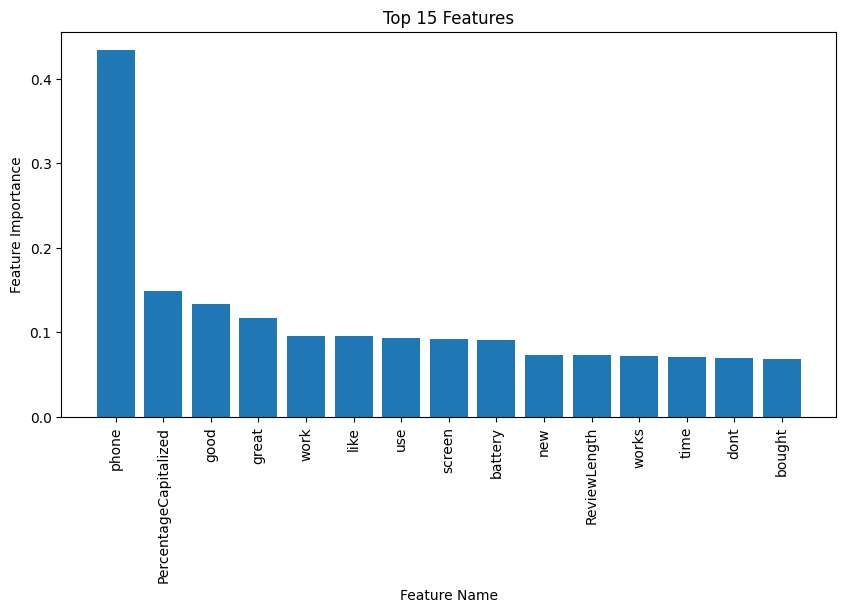

In [ ]:
feature_importances = selector.scores_
indices = np.argsort(feature_importances)[-15:][::-1]  # Show top 15 features
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(range(15), feature_importances[indices], align='center')
plt.xticks(range(15), top_features, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Top 15 Features')
plt.show()

In [ ]:
X_train_chi2 = X_train_selected
X_test_chi2 = X_test_selected

In [ ]:
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
scoring = make_scorer(accuracy_score)

##Naive Bayes

In [ ]:
naive_bayes_pipeline = Pipeline([
    ('clf', MultinomialNB())
])

naive_bayes_param_grid = {
    'clf__alpha': [0.1, 0.5, 1]
}

naive_bayes_grid = GridSearchCV(naive_bayes_pipeline, param_grid=naive_bayes_param_grid, cv=cv, n_jobs=-1, scoring=scoring)
naive_bayes_grid.fit(X_train_chi2, y_train_encoded)

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('clf', MultinomialNB())]), n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.5, 1]},
             scoring=make_scorer(accuracy_score))

##Logistic Regression

In [ ]:
logistic_regression_pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000))
])

logistic_regression_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']
}

logistic_regression_grid = GridSearchCV(logistic_regression_pipeline, param_grid=logistic_regression_param_grid, cv=cv, n_jobs=-1, scoring=scoring)
logistic_regression_grid.fit(X_train_chi2, y_train_encoded)

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10], 'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']},
             scoring=make_scorer(accuracy_score))

##Support Vector Machines

In [ ]:
svm_pipeline = Pipeline([
    ('clf', LinearSVC(max_iter=1000))
])

svm_param_grid = {
    'clf__C': [0.1, 1, 10]
}

svm_grid = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, cv=cv, n_jobs=-1, scoring=scoring)
svm_grid.fit(X_train_chi2, y_train_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('clf', LinearSVC())]), n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10]},
             scoring=make_scorer(accuracy_score))

In [ ]:
naive_bayes_grid.cv_results_

{'mean_fit_time': array([0.41884646, 0.29951053, 0.19667728]),
 'std_fit_time': array([0.03802694, 0.08140864, 0.00669784]),
 'mean_score_time': array([0.02258415, 0.01558664, 0.01186979]),
 'std_score_time': array([0.00470537, 0.00634156, 0.00469844]),
 'param_clf__alpha': masked_array(data=[0.1, 0.5, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__alpha': 0.1}, {'clf__alpha': 0.5}, {'clf__alpha': 1}],
 'split0_test_score': array([0.833028  , 0.83299062, 0.83299062]),
 'split1_test_score': array([0.83859872, 0.83800052, 0.83781359]),
 'split2_test_score': array([0.8383744 , 0.83800052, 0.83796314]),
 'split3_test_score': array([0.83646764, 0.83616854, 0.83594422]),
 'split4_test_score': array([0.83041089, 0.8297753 , 0.82932665]),
 'split5_test_score': array([0.83908476, 0.83882305, 0.83844917]),
 'split6_test_score': array([0.8351217 , 0.83527125, 0.83542079]),
 'split7_test_score': array([0.83800052, 0.83800052, 0.

In [ ]:
logistic_regression_grid.cv_results_

{'mean_fit_time': array([19.90862124, 17.71795382, 49.17122972, 30.29245598, 75.28738809,
        49.30718274]),
 'std_fit_time': array([3.02302445, 1.6168544 , 5.32330672, 0.60281435, 5.57671829,
        1.440132  ]),
 'mean_score_time': array([0.01845295, 0.01821711, 0.01615629, 0.01586685, 0.01516492,
        0.01559463]),
 'std_score_time': array([0.00855246, 0.00921899, 0.005563  , 0.00700278, 0.00301724,
        0.00520226]),
 'param_clf__C': masked_array(data=[0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear'],
              mask=[False, False, False, False, False,

In [ ]:
svm_grid.cv_results_

{'mean_fit_time': array([ 21.90948544, 152.59852343, 407.69125435]),
 'std_fit_time': array([ 1.73474894, 16.18291096,  9.09684892]),
 'mean_score_time': array([0.01699262, 0.01348372, 0.01687465]),
 'std_score_time': array([0.01015798, 0.0020902 , 0.0064426 ]),
 'param_clf__C': masked_array(data=[0.1, 1, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__C': 0.1}, {'clf__C': 1}, {'clf__C': 10}],
 'split0_test_score': array([0.86936853, 0.87019105, 0.87037799]),
 'split1_test_score': array([0.86981718, 0.87007889, 0.86977979]),
 'split2_test_score': array([0.87265862, 0.87501402, 0.87527573]),
 'split3_test_score': array([0.8700415 , 0.87131267, 0.87142483]),
 'split4_test_score': array([0.86607844, 0.86761132, 0.86802258]),
 'split5_test_score': array([0.87288294, 0.87482708, 0.87505141]),
 'split6_test_score': array([0.86933114, 0.87052754, 0.87041537]),
 'split7_test_score': array([0.87078925, 0.87284555, 0.87318204]